
# **CS-331: Introduction to Artificial Intelligence - Project Spring 2024**

## **Robot Path Prediciton**
### **Deadline: $\color{pink}{\text{26th April 2024}}$**

### Submission Instructions

1. All cells must be run once before submission and should $\color{orange}{\text{clearly display the results (graphs/plots/visualizations etc)}}$. Failure to do so will result in 0 marks for that specific part.

2. You are required to zip all your files and upload on LMS in the Project tab by the deadline.

3. The zip file $\color{orange}{\text{MUST}}$ contain your jupyter notebooks (.ipynb) and python script (.py) files for $\color{orange}{\text{EACH}}$ part.

4. The zip file should follow the naming convention "GroupID_rollnumber1_rollnumber2_Project" with 'rollnumber' replaced with each partner's respective ID. If you are not working in a pair, please name the zip file as "rollnumber_Project".

### Late Submission Policy

2. $\color{red}{\text{No submission}}$ will be accepted after the deadline.
2. $\color{red}{\text{No submission}}$ will be accepted via email/Slack, unless announced by the course staff beforehand. It is your responsibility to stay updated with any announcements.

### Plagiarism Policy
All parts of the project are to be done/discussed in group of two (if applicable). The course staff will refer any case of plagiarism
from others or the internet immediately to the DC. If you are confused about what
constitutes plagiarism, it is your responsibility to consult with the TAs
in a timely manner.

### Vivas

The teaching staff reserves the right to conduct a viva for any student. Please do not freeload, any valid complaints from your group partner will be taken seriously and would lead to penalisations.

-----------------------------------------------------------------------

### **Problem Description**

In this project, you will be solving a problem where micro robots are tasked with navigating within a wooden box environment which has obstacles. Your objective is to predict the trajectory of the robot over a specified duration based on historical video data.

### **Time Series and Lookback**

The data we have is $\color{orange}{\text{time-series}}$. You will come across this data type very often in this field, since it forms the basis for many AI-based tasks. Let us learn some concepts regarding that. <br/>
A time series dataset is a collection of data points (or observations) recorded at successive, equally spaced intervals of time, with the intention of analyzing patterns/trend, and behavior of a feature over time.
For example, if we have a feature's values across a 10 timestep window i.e., `[t-10, t-9, t-8, ... t-1]` we can predict its value at time step `t` based on aggregated information from the previous timesteps. </br>

#### Lookback
The lookback concept in time series analysis refers to the number of previous observations used as input when predicting the next value in the series. It determines how far back in time the model "looks" to gather information for making predictions. For example, with a lookback of one, only the immediately preceding observation is used for prediction, while with a lookback of two, the two previous observations are considered, and so on. Consider these examples: <br/>

**Lookback of One** <br/>
Input: (502, 59) -> Output: (506, 59)

**Look-back of Two** <br/>
Input: ((496, 63), (502, 59)) -> Output: (506, 59)

### **Dataset Overview**

You have the following format for train and test data in this project:

* Training Data
  - A 1200-second video recording `(training_data.mp4)` of the robot's movement within the wooden box environment. This video is captured at 30 frames per second (fps).
  - A text file  `(training_data.txt)`containing the robot's coordinates, with 30 values recorded for each second (since video is 30 fps).

* Testing Data
  - A test video `(test01.mp4)`, 60 seconds long recorded at 30 fps.
  - A test txt file `(test01.txt)` following the same format as the `training_data.txt` file.

### **Objective**

Your goal is to forecast the positions of the robot using KNN, Regression Tree (decision trees that can take continuous values instead of class labels), and Neural Networks.

# **Part 1A: KNN from Scratch [30 marks]**

You are $\color{red}{\text{NOT}}$ allowed to use scikit-learn or any other machine learning toolkit for this part (Part 1A). You have to implement your own kNN model. However, you can use numpy, matplotlib, seaborn, and other standard Python libraries for this part. Contact the TAs if you want to use any other libraries.

### Imports

In [71]:
# import all required libraries here
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# mount the drive if you are using google colab

### Loading and Preprocessing the Dataset

Get the training and testing data `(trainX and testX)` (you may use the function below to preprocess it). Further, think about how you would form the predictions array `(trainY and testY)` using a lookback of 1.

In [72]:
# Do not edit this cell
def process_data(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
    data = []
    for line in lines:          # process the lines to extract x and y coordinates
        x_str, y_str = line.strip().split(',')
        x = int(x_str)
        y = int(y_str)
        data.append([x, y])     # store x and y coordinates for each time step
    data = np.array(data)
    return data



def create_lookback_dataset(data, lookback):
   
    X, Y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback)].flatten())  # Flattening the window
        Y.append(data[i + lookback])
    return np.array(X), np.array(Y)


train = process_data(r'Dataset/Training/training_data.txt')
test = process_data(r'Dataset/Testing/test01.txt')
lookback = 1
X_train , y_train = create_lookback_dataset(train, lookback)
x_test, y_test = create_lookback_dataset(test, lookback)







### Implement K-Nearest Neighbors (KNN) from Scratch

  * Develop the KNN algorithm.
  * This involves creating functions for calculating distances between data points, finding nearest neighbors, and making predictions.
  * For values of k where a tie occurs, you will need to break the tie by backing off to k-1 value. In case the tie persists, you will need to keep descreasing k till you get a clear winner.
  * Use Euclidean distance in your kNN classifier
$$
d_{\text{Euclidean}}(\vec{p},\vec{q}) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + (p_3 - q_3)^2 + ... + (p_n - q_n)^2}
$$


In [73]:
# code here 
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def knn_regression(X_train, y_train, X_test, k=3):
    predictions = []
    for test_point in X_test:
        distances = []
        for i in range(len(X_train)):
            dist = euclidean_distance(test_point, X_train[i])
            distances.append((y_train[i], dist))
        distances.sort(key=lambda x: x[1])
        weighted_sum = np.zeros(len(y_train[0]))
        weight_sum = 0
        for i in range(k):
            label, dist = distances[i]
            if dist == 0:
                weighted_sum = label
                weight_sum = 1
                break
            else:
                weight = 1 / dist
                weighted_sum += label * weight
                weight_sum += weight
        predictions.append(weighted_sum / weight_sum if weight_sum != 0 else weighted_sum)
    return np.array(predictions)
list1 = [2, 4, 6, 8, 10]
pred_rmse = []

for k in list1:
    y_cap = knn_regression(X_train, y_train, x_test, k=k)
    rmse = np.sqrt(mean_squared_error(y_test, y_cap))
    pred_rmse.append(rmse)
    print(rmse)

7.2320156553290875


KeyboardInterrupt: 

### Evaluation and Analysis

*  Plot a line graph to evaluate your model's performance (using RMSE) across a reasonable range of K values `i.e., 2, 4, 6, 8, 10`, and explain the trend in your graph. Be sure to also identify optimal k value and add reasoning for your choice. <br/>

* Note that our model predicts both x and y coordinates at once, thus the RMSE needs to account for that. (This is a useful trick to remember for your future AI-based projects!)

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}i)^2} + \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

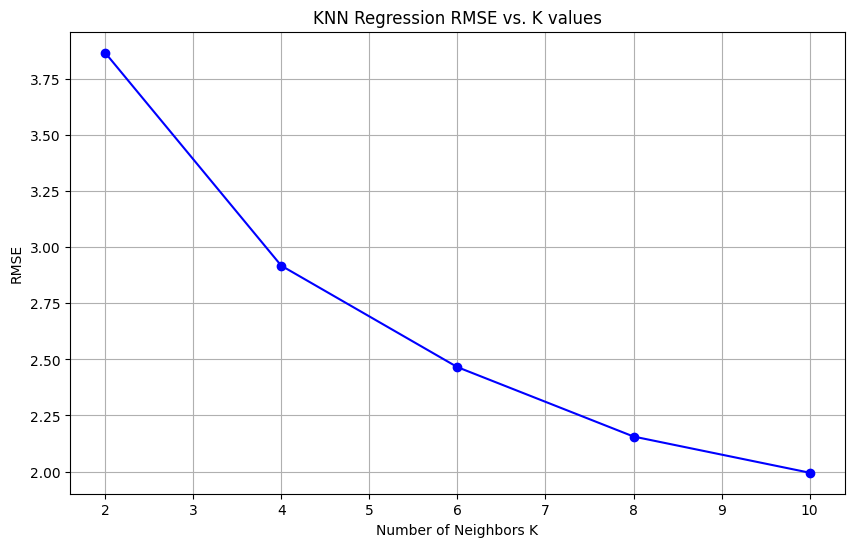

In [ ]:
# code here
plt.figure(figsize=(10, 6))
plt.plot(list1, pred_rmse, marker='o', linestyle='-', color='b')
plt.title('KNN Regression RMSE vs. K values(From scrach)')
plt.xlabel('Number of Neighbors K')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

### Double Click to $\color{green}{\text{add explanation/reasoning here}}$

### Visualization of Actual and Predicted Path

Compare the actual trajectory of robot with the one predicted by your KNN model for a 6 second interval of your choice from the testing video to check the performance of your model. Do this by plotting both paths on a single graph. The following  $\color{pink}{\text{important}}$ points may help you with figuring how to do this:

* For the actual trajectory/path, consider how the test video maps to the txt files based on fps rate provided earlier. How many points should you choose for the required interval?

* Which KNN model from the above ones should you choose and why? (provide a one-liner description)

* Based on the chosen time interval (e.g. 9-15 seconds), what should be the input to the KNN model (remember that your model is using a lookback of 1) such that the output corresponds to the same timesteps as the actual trajectory?


In [74]:
# plot the actual and predicted paths

k = 10

start_index = 100 
end_index = start_index + 180  
actual_path = test[start_index:end_index]
y_cap = knn_regression(X_train, y_train, x_test, k=k)
y_pred_temp = y_cap[start_index:end_index]
plt.figure(figsize=(12, 6))
plt.plot(actual_path,y_pred_temp, label='Actual Path', marker='o', linestyle='-', markersize=5)
plt.title('Actual vs Predicted Path Comparison')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

# **Part 1B: KNN using scikit-learn [10 marks]**

In this part, you will implement KNN using scikit-learn (so you can independently check how well your KNN model performs compared to state-of-the-art instead of asking the TAs).

- Repeat the same process that you did in Part1A for plotting the actual and predicted paths. Use the same time interval from the testing data as before (kind of understood since it is a comparison, but doesn't hurt to clarify).


3.867893885933334
2.9180606266854143


2.465621194745962
2.1560769148131813
1.994647506965281


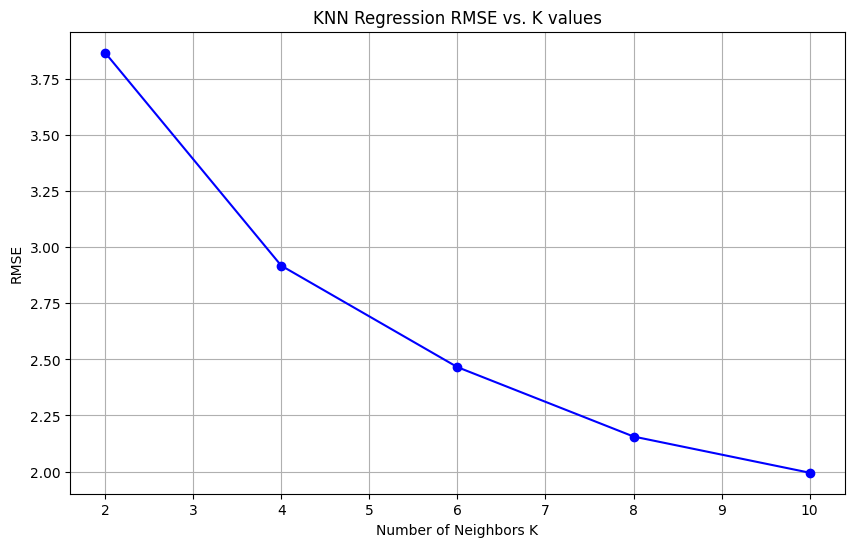

In [ ]:
# code here
list1 = [2,4,6,8,10]

pred_rmse = []
for x in list1:
 model = KNeighborsRegressor(n_neighbors=x)
 model.fit(X_train, y_train)
 y_cap = model.predict(x_test)
 #print(y_cap.shape)
 rmse = np.sqrt(mean_squared_error(x_test, y_cap))
 pred_rmse.append(rmse)
 print(rmse)
plt.figure(figsize=(10, 6))
plt.plot(list1, pred_rmse, marker='o', linestyle='-', color='b')
plt.title('KNN Regression RMSE vs. K values')
plt.xlabel('Number of Neighbors K')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

 

